# 03 - Producción de energía eléctrica

En el presente análisis realizaremos una estimación de la producción de energía eléctrica por metro cuadrado de superficie de paneles solares. Para lograr esto se realizará una estimación de la disponibilidad de recurso energético disponible en el plano generalizado que representará el plano de proyección conformado por los paneles solares y posterior a eso, se realizará una corrección de la energía eléctrica generada a partir de este recurso disponible, la eficiencia de producción de los paneles y la pérdida de eficiencia debida a la temperatura ambiental.



In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Crear dataframe con los sets de datos de NREL
import nrel_system.parse_nrel as parse_nrel

merida = [
    "data/mx-merida/2018.csv",
    "data/mx-merida/2019.csv",
    "data/mx-merida/2020.csv"
]

nrel, L = parse_nrel.main(merida)

In [3]:
# Calcular (e inyectar) variables de temporales, de geometría solar y valores de irradiancia por componentes difusa y directa
import physical_system.setup_variables as setup_variables
nrel = setup_variables.main(nrel,L)

In [4]:
# Realizar cálculo de proyección de irradiancia en plano generalizado utilizando como parámetros de plano 
#     el ángulo acimutal solar y el ángulo de inclinación planar
import projection_system.setup_projection as setup_projection

## Cálculo de recurso energético disponible

Teniendo la posibilidad de calcular la irradiancia proyectada en un plano generalizado parametrizado por los parámetros de orientación acimutal e inclinación con respecto al suelo, es posible simular múltiples configuraciones al varias estos parámetros, calcular la irrandiancia proyectada y con eso, calcular la cantidad de energía total que fluye a través del plano y que es posible almacenar como energía eléctrica.

Para lograr esto, estimaremos el recurso energético disponible para un rango discreto de valores enteros de BETA. A partir de esto generaremos la cantidad total de recurso energético acumulado para diferentes periodos de tiempo, siendo el de mayor interés el recurso energético acumulado a lo largo de un año. 

Con esto lograremos obtener una lista de estimaciones de energía producida en los periodos de tiempo de interés para el rango definido de ángulos de inclinación, que una vez graficadas podrán apreciarse como una curva aproximadamente contínua con un valor máximo de producción de energía para un ángulo de inclinación específico. Habiendo encontrado este valor de producción de energía máximo, sabremos que hemos dado con el ángulo de inclinación óptimo para la generación de energía solar dentro del periodo en cuestión.


In [9]:
# Importamos librería de estimación de producción de energía para un plano parametrizado
import forecast_system.setup_production_forecast as setup_production_forecast

def forecast_nrel(nrel,BETA,B=0):
    # Definimos el set de columnas de interés para el presente análisis de recurso energético
    df = setup_projection.main(nrel,B,BETA=BETA)
    df = setup_production_forecast.main(df)
    cols = ['YEAR','MONTH','DAY','HOUR','MINUTE','TEMPERATURE','A','ALPHA','BETA','I_PROJ','WH_SQM']
    return df[cols]

### Producción de energía anual 

In [25]:

BETA_LIST = np.arange(20,30)

for BETA in BETA_LIST:
    nrel_BETA = forecast_nrel(nrel,BETA)
    nrel['WH_SQM_'+str(BETA)] = nrel_BETA.WH_SQM
    
nrel.columns

Index(['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'MINS_SINCE_EQUINOX',
       'TEMPERATURE', 'DNI', 'DHI', 'GHI', 'GI', 'X_DIF', 'X_DIR', 'Z', 'D',
       'H', 'A', 'ALPHA', 'B', 'BETA', 'WH_SQM_15', 'WH_SQM_16', 'WH_SQM_17',
       'WH_SQM_18', 'WH_SQM_19', 'WH_SQM_20', 'WH_SQM_21', 'WH_SQM_22',
       'WH_SQM_23', 'WH_SQM_24', 'WH_SQM_25', 'WH_SQM_26', 'WH_SQM_27',
       'WH_SQM_28', 'WH_SQM_29', 'WH_SQM_30', 'WH_SQM_31', 'WH_SQM_32',
       'WH_SQM_33', 'WH_SQM_34', 'WH_SQM_35', 'WH_SQM_36', 'WH_SQM_37',
       'WH_SQM_38', 'WH_SQM_39', 'WH_SQM_40', 'WH_SQM_41', 'WH_SQM_42',
       'WH_SQM_43', 'WH_SQM_44', 'WH_SQM_45', 'WH_SQM_46', 'WH_SQM_47',
       'WH_SQM_48', 'WH_SQM_49'],
      dtype='object')

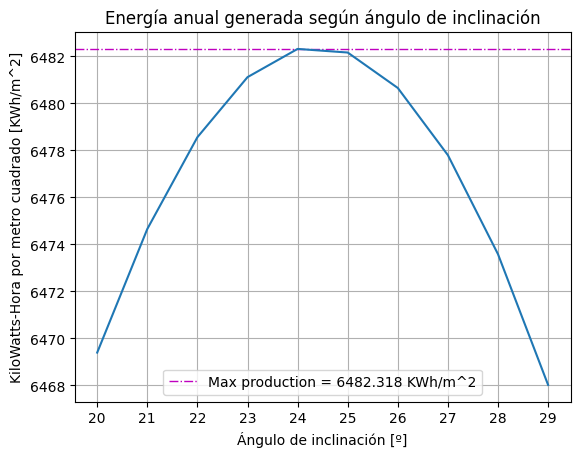

In [47]:

produced = []
for BETA in BETA_LIST:
    col = 'WH_SQM_'+str(BETA)
    produced.append(nrel[col].sum()/1000)

max_prod = np.round(np.max(produced),3)
plt.xticks(BETA_LIST)
plt.grid(True)
plt.ylabel('KiloWatts-Hora por metro cuadrado [KWh/m^2]')
plt.xlabel('Ángulo de inclinación [º]')
plt.title('Energía anual generada según ángulo de inclinación')
plt.axhline(y=np.max(max_prod), color='m',linestyle='-.',linewidth=1,label='Max production = ' + str(max_prod) + ' KWh/m^2')
plt.legend(loc='lower center')
plt.plot(BETA_LIST,produced)


Gracias a las estimaciones realizadas para múltiples ángulos de inclinación hemos logrado determinar que el ángulo óptimo es de 24º, con una producción estimada de energía eléctrica de 6482.3 KWh por metro cuadrado; antes de correcciones de eficiencia de los paneles. 